# Music and the Brain 
## 0. Setup and load data from 0.[decoding]feature-extraction notebook.

In [1]:
import os 
import pickle
import nilearn
import joblib as jl

import numpy as np
import pandas as pd

import nibabel as nib

from nilearn import plotting
from nilearn import image
from nilearn.plotting import plot_anat, plot_img, plot_stat_map

In [2]:
# Set the path to the data directory
src_dir = '../data/derivatives/nilearn'

# Set the participant and session IDs
part_id = 'sub-02'
ses_id = 'ses-01'


In [3]:
data_dir = os.path.join(src_dir, part_id, ses_id)

In [4]:
# Load feature set.
X = image.load_img(os.path.join(data_dir, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_clean.nii.gz')) #Clean beacuse it removed the noise (baseline)

# Load csv file with targets.
target_set = pd.read_csv(os.path.join(data_dir, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_targets_clean.csv'))

# Load csv file with groups.
group_set = pd.read_csv(os.path.join(data_dir, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_groups_clean.csv')) 

In [5]:
# Load mask.
mask_img = image.load_img(os.path.join(data_dir, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_mask.nii.gz')) #o  nome é diferente

# 1. Classification

In [6]:
from nilearn.maskers import NiftiMasker
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.pipeline import Pipeline

from nilearn.decoding import Decoder
# “background”: Use this option if your images present a clear homogeneous background.
# “whole-brain-template”: This will extract the whole-brain part of your data by resampling 
# the MNI152 brain mask for your data’s field of view.


logo = LeaveOneGroupOut()


In [7]:
# concat images in list
# X = nilearn.image.concat_imgs(list(image_set.values()))
print(X.shape)


(97, 115, 97, 72)


## 1.1 Create target vector

In [8]:
y = list(target_set['target'].values)

# transform the target_set unique strings to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 0 agaisnt all others
# y = np.where(y == 1, 0, 1)
print(y)


[5 5 8 8 1 1 2 2 7 7 4 4 3 3 6 6 0 0 7 7 4 4 6 6 0 0 3 3 5 5 8 8 1 1 2 2 4
 4 0 0 5 5 6 6 3 3 1 1 8 8 2 2 7 7 4 4 2 2 7 7 5 5 8 8 0 0 3 3 1 1 6 6]


In [9]:
runs_group = group_set['group'].values

print(runs_group)

# unique values in runs_group
print(np.unique(runs_group))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[0 1 2 3]


## 1.2 Classification model
### 1.2.1 Nilearn wrapper

In [10]:
# def run_decoder(estimator, mask, cv, X, y, groups, smoothing, scoring, mask_strategy, results_dir, part_id):
#     """
#    Function to fit the Nilearn Decoder and save the results in CSV files, with support for creating directories
# and updating existing files.

# Args:
#     estimator (str): Type of estimator (e.g., 'svc_l1').
#     mask (str): Path to the mask image.
#     cv (object): Cross-validation strategy.
#     X (array): Input data.
#     y (array): Labels.
#     smoothing (int): fwhm value.
#     scoring (str): Evaluation method.
#     mask_strategy (str): Masking strategy.
#     results_dir (str): Base directory to save the results.
    

# Returns:
#     dict: Dictionary with the aggregated results.
#     """
   
#     decoder_name = f"{estimator}_{mask_strategy}_fwhm{smoothing}_{scoring}"
#     filename = f"{decoder_name}.csv"
    
#     output_dir = os.path.join(results_dir, 'nilearn', part_id)
   
#     if not os.path.exists(output_dir):
#             os.makedirs(output_dir)


#     filepath = os.path.join(output_dir, filename)
    
#     try:
        
#         decoder = Decoder(
#             estimator=estimator,
#             mask=mask,
#             cv=cv,
#             smoothing_fwhm=smoothing,
#             mask_strategy=mask_strategy,
#             scoring=scoring,
#             standardize=True,
#             verbose=0
#         )
#         decoder.fit(X, y, groups=groups)
        
#         # get values of decoder_LogisticL1.cv_scores_ per fold and create list
#         cv_scores = [decoder.cv_scores_[i] for i in range(len(decoder.cv_scores_))]

#         # mean of cv_scores per class
#         cv_scores_mean = np.mean(cv_scores, axis=1)
        
#         # Criar DataFrame com os resultados
#         df = pd.DataFrame(cv_scores_mean, columns=['score'])
#         df['label'] = le.classes_ # Use class labels from cv_scores_ keys

        
#         # Se o ficheiro já existir, carregar e anexar os novos dados
#         if os.path.exists(filepath):
#             df_existing = pd.read_csv(filepath)
#             df = pd.concat([df_existing, df], ignore_index=True)

#         df = pd.DataFrame({'target': le.classes_, 'cv_score': cv_scores_mean})

#         # Salvar o DataFrame atualizado
#         df.to_csv(filepath, index=False)
#         print(f"Resultados salvos em: {filepath}")
#         print(df)
        
#         return {
#             "Decoder": decoder_name,
#             "Smoothing": smoothing,
#             "Scoring Method": scoring,
#             "Mask Strategy": mask_strategy,
#             "Mean Score": cv_scores_mean,
#             "Filepath": filepath
#         }
    
#     except Exception as e:
#         print(f"Erro com {decoder_name}: {e}")
#         return {
#             "Decoder": decoder_name,
#             "Smoothing": smoothing,
#             "Scoring Method": scoring,
#             "Mask Strategy": mask_strategy,
#             "Mean Score": None,
#             "Error": str(e),
#             "Filepath": filepath
        }

In [ ]:
# results_dir = '../results_seb'
# part_id = 'sub-01'  # 
# ses_id = 'ses-01'  # 

# estimators = ['svc_l1', 'svc_l2'] 
# scoring_metrics = ['roc_auc', 'accuracy']  # scoring metrics
# smoothing_values = [2, 3, 5, 8]  # fwhm values
# mask_strategies = ['whole-brain-template', 'gm-template'] 



# all_results = []

# for estimator in estimators:
#     for scoring_method in scoring_metrics:
#         for smoothing in smoothing_values:
#             for mask_strategy in mask_strategies:
#                 result = run_decoder(
#                     estimator= estimator,
#                     mask=mask_img,
#                     cv=logo,
#                     X=X,
#                     y=y,
#                     part_id=part_id,
#                     groups=runs_group,
#                     smoothing=smoothing,
#                     scoring=scoring_method,
#                     mask_strategy=mask_strategy,
#                     results_dir=results_dir,
                    
#                 )
#                 all_results.append(result)




In [10]:
def run_decoder(estimator, mask, cv, X, y, groups, smoothing, scoring, mask_strategy, results_dir, part_id, ses_id):
    """
    Function to fit the Nilearn Decoder, save the model, and organize results into structured directories.
    """
    decoder_name = f"{estimator}_{mask_strategy}_fwhm{smoothing}_{scoring}"
    scoring_dir = os.path.join(results_dir, 'nilearn', part_id, ses_id, scoring)
    decoder_path = os.path.join(scoring_dir, f"{decoder_name}.pkl")
    
    if not os.path.exists(scoring_dir):
        os.makedirs(scoring_dir)
    
    try:
        
        
        # Initialize and fit decoder
        decoder = Decoder(
            estimator=estimator,
            mask=mask,
            cv=cv,
            smoothing_fwhm=smoothing,
            mask_strategy=mask_strategy,
            scoring=scoring,
            standardize=True,
            verbose=0
        )
        decoder.fit(X, y, groups=groups)
        
        # Save decoder
        with open(decoder_path, 'wb') as f:
            pickle.dump(decoder, f)
        print(f"Decoder salvo em: {decoder_path}")
        
        return {
            "Decoder": decoder_name,
            "Smoothing": smoothing,
            "Scoring Method": scoring,
            "Mask Strategy": mask_strategy,
            "Decoder Path": decoder_path
        }
    
    except Exception as e:
        print(f"Erro com {decoder_name}: {e}")
        return {
            "Decoder": decoder_name,
            "Smoothing": smoothing,
            "Scoring Method": scoring,
            "Mask Strategy": mask_strategy,
            "Error": str(e),
            "Decoder Path": decoder_path
        }

In [11]:
def find_all_decoders(base_dir, scoring_methods):
    """
    Procura e carrega automaticamente todos os arquivos .pkl dentro das pastas de scoring (ex: 'roc_auc' ou 'accuracy').

    Args:
        base_dir (str): Diretório base onde estão as pastas de scoring.
        scoring_methods (list): Lista das pastas possíveis de scoring.

    Returns:
        list: Lista de tuples contendo (decoder, decoder_path, scoring_method).
    """
    decoders_list = []

    for method in scoring_methods:
        scoring_path = os.path.join(base_dir, method)

        if os.path.exists(scoring_path):  # Verifica se a pasta existe
            for file in os.listdir(scoring_path):  # Percorre os arquivos
                if file.endswith(".pkl"):  # Procura arquivos .pkl
                    decoder_path = os.path.join(scoring_path, file)
                    try:
                        with open(decoder_path, 'rb') as f:
                            decoder = pickle.load(f)
                        print(f"Decoder carregado de: {decoder_path}")
                        decoders_list.append((decoder, decoder_path, method))  # Armazena o decoder, caminho e a pasta de origem
                    except Exception as e:
                        print(f"Erro ao carregar decoder de {decoder_path}: {e}")

    if decoders_list:
        return decoders_list  # Retorna todos os decoders encontrados
    else:
        print("Nenhum decoder encontrado!")
        return []  # Retorna lista vazia se nada for encontrado


In [12]:
def save_results(decoder, results_dir, part_id, ses_id):
    """Save CV scores and coefficient images."""

    decoder_name = os.path.splitext(os.path.basename(decoder[1]))[0] # Get decoder name from decoder[1] -> path splitext[0] = takes out the .pkl

    # cv_scores_path = os.path.join(results_dir, 'nilearn', part_id, ses_id, 'cv_scores', decoder[2], decoder_name)
    path = os.path.join(results_dir, 'nilearn', part_id, ses_id, decoder[2], decoder_name)

    if not os.path.exists(path):
        os.makedirs(path)

    # if not os.path.exists(coef_imgs_path):
    #     os.makedirs(coef_imgs_path)

    
    
    # Save cross-validation scores

    cv_scores = [decoder[0].cv_scores_[i] for i in range(len(decoder[0].cv_scores_))]

    cv_scores_mean = np.mean(cv_scores, axis=1)

    df = pd.DataFrame(cv_scores_mean, columns=['score'])
    df['label'] = le.classes_ # Use class labels from cv_scores_ keys


    df = pd.DataFrame({'target': le.classes_, 'cv_score': cv_scores_mean})

    csv_path = os.path.join(path, f"{decoder_name}_cv_scores.csv")
    df.to_csv(csv_path, index=False)

    #print(f"Resultados salvos em: {csv_path}")
    
    coef_img = [decoder[0].coef_img_[i] for i in range(len(decoder[0].coef_img_))]

    coef_final_path = os.path.join(path, f"{decoder_name}_coef_img.pkl")

    
    jl.dump(coef_img, coef_final_path)
    
       
    # Save coefficient images
    #coef_imgs = enumerate(decoder[0].coef_img_):

        
        
        
    

In [13]:
import os
import joblib

def find_all_coefs(base_dir, scoring_methods):
    """
    Recursively searches for .pkl files within scoring method directories and loads them using joblib.

    Args:
        base_dir (str): Base directory where the scoring method folders are located.
        scoring_methods (list): List of scoring method folder names (e.g., 'roc_auc', 'accuracy').

    Returns:
        list: List of tuples containing (coef_img, coef_path, scoring_method).
    """
    coefs_list = []

    for method in scoring_methods:
        scoring_path = os.path.join(base_dir, method)

        if os.path.exists(scoring_path):  # Check if the scoring folder exists
            for root, _, files in os.walk(scoring_path):  # Recursively walk through all subdirectories
                for file in files:
                    if file.endswith(".pkl"):  # Look for .pkl files
                        coef_path = os.path.join(root, file)
                        try:
                            coef_img = joblib.load(coef_path)  # Load using joblib
                            print(f"Loaded coefficient from: {coef_path}")
                            coefs_list.append((coef_img, coef_path, method))  # Store coef_img, path, and scoring method
                        except Exception as e:
                            print(f"Error loading coefficient from {coef_path}: {e}")

    if coefs_list:
        return coefs_list  # Return all found coefficients
    else:
        print("No coefficient files found!")
        return []  # Return an empty list if nothing is found



In [75]:
# Definir diretórios e parâmetros
decoders_dir = '../decoders_dir'
part_id = 'sub-01'
ses_id = 'ses-01'
estimators = ['svc_l2']
scoring_metrics = ['roc_auc']
smoothing_values = [4]
mask_strategies = ['whole-brain-template', 'gm-template']

all_results = []

for estimator in estimators:
    for scoring_method in scoring_metrics:
        for smoothing in smoothing_values:
            for mask_strategy in mask_strategies:
                result = run_decoder(
                    estimator=estimator,
                    mask=mask_img,
                    cv=logo,
                    X=X,
                    y=y,
                    part_id=part_id,
                    ses_id=ses_id,
                    groups=runs_group,
                    smoothing=smoothing,
                    scoring=scoring_method,
                    mask_strategy=mask_strategy,
                    results_dir=decoders_dir,
                )
                # all_results.append(result)

# summary_df = pd.DataFrame(all_results)
# summary_filepath = os.path.join(results_dir, 'decoder_results_summary.csv')
# summary_df.to_csv(summary_filepath, index=False)
# print(f"Resumo salvo em: {summary_filepath}")

c:\Users\sebas\miniconda3\envs\nilearntest\lib\site-packages\joblib\memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


Decoder salvo em: ../decoders_dir\nilearn\sub-01\ses-01\roc_auc\svc_l2_whole-brain-template_fwhm4_roc_auc.pkl


c:\Users\sebas\miniconda3\envs\nilearntest\lib\site-packages\joblib\memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


Decoder salvo em: ../decoders_dir\nilearn\sub-01\ses-01\roc_auc\svc_l2_gm-template_fwhm4_roc_auc.pkl


In [14]:
# Diretório base onde estão as pastas 'roc_auc' e 'accuracy'
base_decoder_dir = r"..\decoders_dir\nilearn\sub-01\ses-01"

# Lista das subpastas onde pode estar o decoder
scoring_methods = ["roc_auc", "accuracy"]


# Chama a função para encontrar todos os decoders
decoders = find_all_decoders(base_decoder_dir, scoring_methods)


Decoder carregado de: ..\decoders_dir\nilearn\sub-01\ses-01\roc_auc\svc_l1_gm-template_fwhm2_roc_auc.pkl
Decoder carregado de: ..\decoders_dir\nilearn\sub-01\ses-01\roc_auc\svc_l1_whole-brain-template_fwhm2_roc_auc.pkl
Decoder carregado de: ..\decoders_dir\nilearn\sub-01\ses-01\roc_auc\svc_l2_gm-template_fwhm4_roc_auc.pkl
Decoder carregado de: ..\decoders_dir\nilearn\sub-01\ses-01\roc_auc\svc_l2_whole-brain-template_fwhm4_roc_auc.pkl
Decoder carregado de: ..\decoders_dir\nilearn\sub-01\ses-01\accuracy\svc_l1_gm-template_fwhm2_accuracy.pkl
Decoder carregado de: ..\decoders_dir\nilearn\sub-01\ses-01\accuracy\svc_l1_whole-brain-template_fwhm2_accuracy.pkl


In [15]:
if decoders:
    results_dir = '../results_seb'
    part_id = 'sub-01'
    ses_id = 'ses-01'

    for decoder in decoders:

        # Acessa o cv_scores_ corretamente
        save_results(decoder,results_dir, part_id, ses_id)

        

       
        


In [25]:
coef_imgs = jl.load(r'..\results_seb/nilearn/sub-01/ses-01/roc_auc/svc_l2_gm-template_fwhm4_roc_auc/svc_l2_gm-template_fwhm4_roc_auc_coef_img.pkl')
print(coef_imgs)


[<nibabel.nifti1.Nifti1Image object at 0x00000130935670A0>, <nibabel.nifti1.Nifti1Image object at 0x0000013093397040>, <nibabel.nifti1.Nifti1Image object at 0x00000130933AFD60>, <nibabel.nifti1.Nifti1Image object at 0x00000130932F75E0>, <nibabel.nifti1.Nifti1Image object at 0x00000130934EE340>, <nibabel.nifti1.Nifti1Image object at 0x000001309344E370>, <nibabel.nifti1.Nifti1Image object at 0x00000130947F6100>, <nibabel.nifti1.Nifti1Image object at 0x00000130934DCD00>, <nibabel.nifti1.Nifti1Image object at 0x00000130935A0730>]


In [16]:
base_coef_dir = r"..\results_seb\nilearn\sub-01\ses-01"
scoring_methods = ["roc_auc", "accuracy"]


coefs = find_all_coefs(base_coef_dir, scoring_methods)

Loaded coefficient from: ..\results_seb\nilearn\sub-01\ses-01\roc_auc\svc_l1_gm-template_fwhm2_roc_auc\svc_l1_gm-template_fwhm2_roc_auc_coef_img.pkl
Loaded coefficient from: ..\results_seb\nilearn\sub-01\ses-01\roc_auc\svc_l1_whole-brain-template_fwhm2_roc_auc\svc_l1_whole-brain-template_fwhm2_roc_auc_coef_img.pkl
Loaded coefficient from: ..\results_seb\nilearn\sub-01\ses-01\roc_auc\svc_l2_gm-template_fwhm4_roc_auc\svc_l2_gm-template_fwhm4_roc_auc_coef_img.pkl
Loaded coefficient from: ..\results_seb\nilearn\sub-01\ses-01\roc_auc\svc_l2_whole-brain-template_fwhm4_roc_auc\svc_l2_whole-brain-template_fwhm4_roc_auc_coef_img.pkl
Loaded coefficient from: ..\results_seb\nilearn\sub-01\ses-01\accuracy\svc_l1_gm-template_fwhm2_accuracy\svc_l1_gm-template_fwhm2_accuracy_coef_img.pkl
Loaded coefficient from: ..\results_seb\nilearn\sub-01\ses-01\accuracy\svc_l1_whole-brain-template_fwhm2_accuracy\svc_l1_whole-brain-template_fwhm2_accuracy_coef_img.pkl


In [17]:
print(coefs[0][1])

..\results_seb\nilearn\sub-01\ses-01\roc_auc\svc_l1_gm-template_fwhm2_roc_auc\svc_l1_gm-template_fwhm2_roc_auc_coef_img.pkl


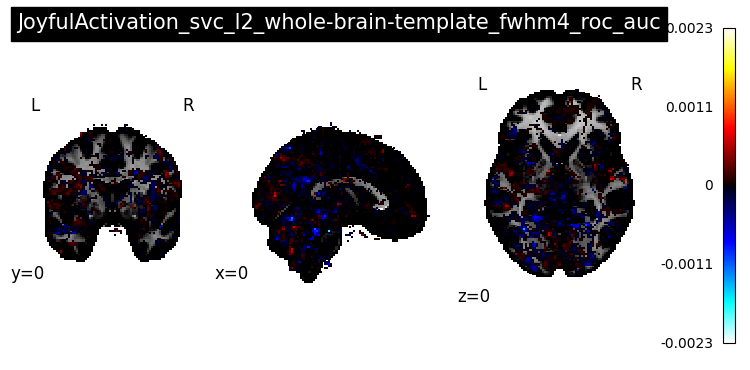

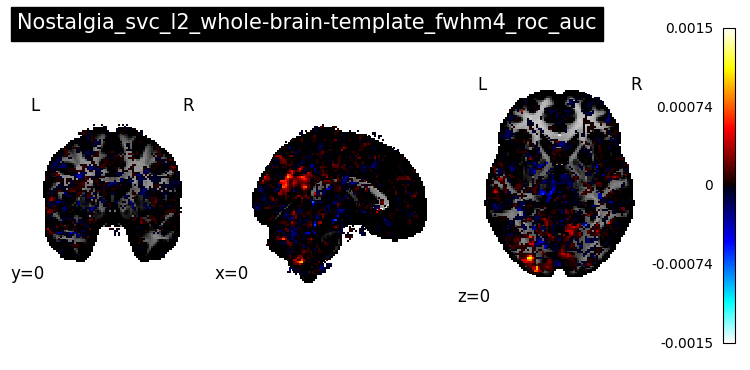

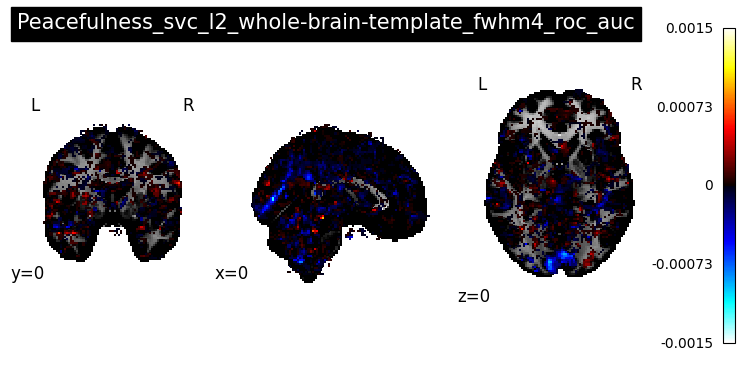

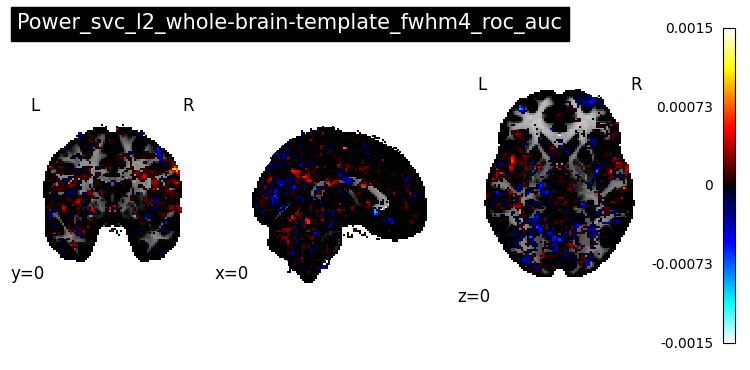

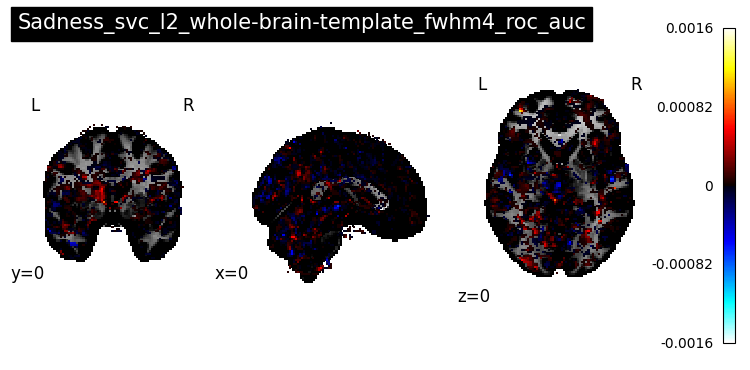

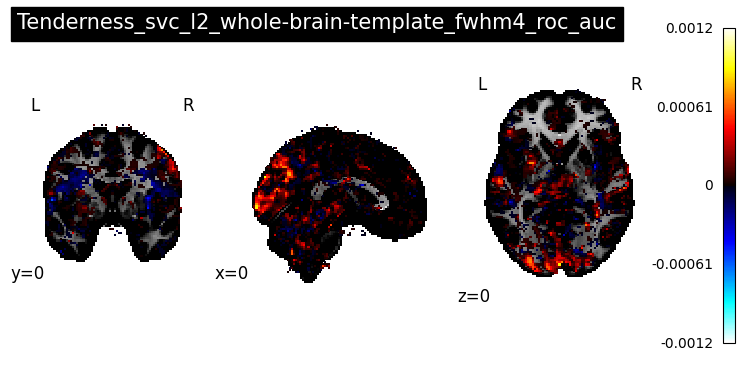

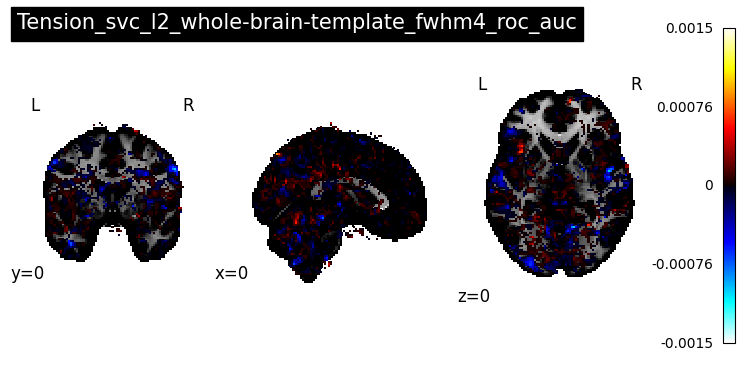

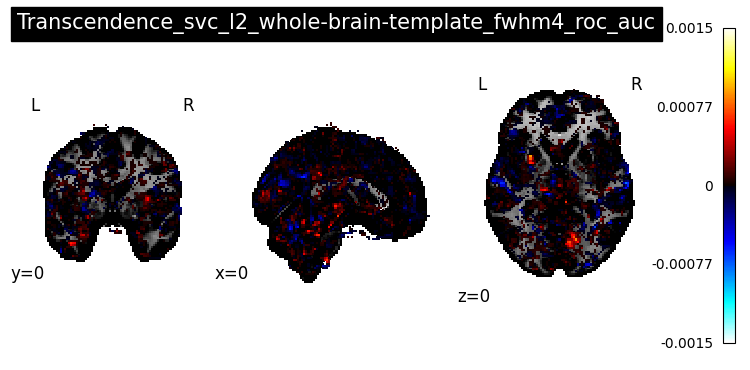

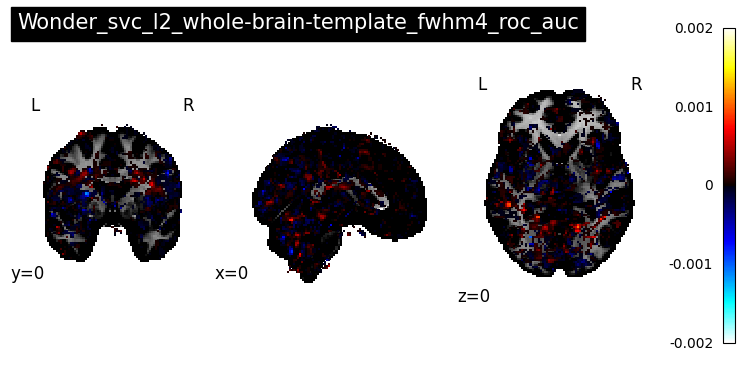

In [26]:
for i in range(len(np.unique(y))):

    # get the indices of the target_set
    idx = np.where(y == i)

    subfolder_name = os.path.basename(os.path.dirname(coefs[3][1]))
    


    # plot the cv_scores_mean_i
    plt = plotting.plot_stat_map(
        coef_imgs[i],
        title=f'{le.inverse_transform([i])[0]}_{subfolder_name}',
        dim=-1,
        threshold='auto',
        cut_coords=(0, 0, 0),
        draw_cross=False,
        
    
        
    )


In [18]:
from nilearn.image import mean_img


# compute sum of all images in list

# for each image in the list extract the data and sum them
imgs = list(coefs[3][0])
print(imgs)


# create list img_data
img_data = []

i = 0
for img in imgs:
    # compute the absolute value of the image data
    img_data.append(np.abs(img.get_fdata()))
    print(img_data[i].shape)

    i += 1




[<nibabel.nifti1.Nifti1Image object at 0x000001301F7A0F70>, <nibabel.nifti1.Nifti1Image object at 0x000001301F7A0B80>, <nibabel.nifti1.Nifti1Image object at 0x000001301F7A0760>, <nibabel.nifti1.Nifti1Image object at 0x000001301F7A91C0>, <nibabel.nifti1.Nifti1Image object at 0x000001301F7A93D0>, <nibabel.nifti1.Nifti1Image object at 0x000001301F7A9550>, <nibabel.nifti1.Nifti1Image object at 0x000001301F7A96D0>, <nibabel.nifti1.Nifti1Image object at 0x000001301F7A9850>, <nibabel.nifti1.Nifti1Image object at 0x000001301F7A99D0>]
(97, 115, 97)
(97, 115, 97)
(97, 115, 97)
(97, 115, 97)
(97, 115, 97)
(97, 115, 97)
(97, 115, 97)
(97, 115, 97)
(97, 115, 97)


In [19]:
img_data = np.array(img_data)
mean_img_coef = np.sum(img_data, axis=0)
mean_img_coef = nib.Nifti1Image(mean_img_coef, mask_img.affine)

c:\Users\sebas\miniconda3\envs\nilearntest\lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



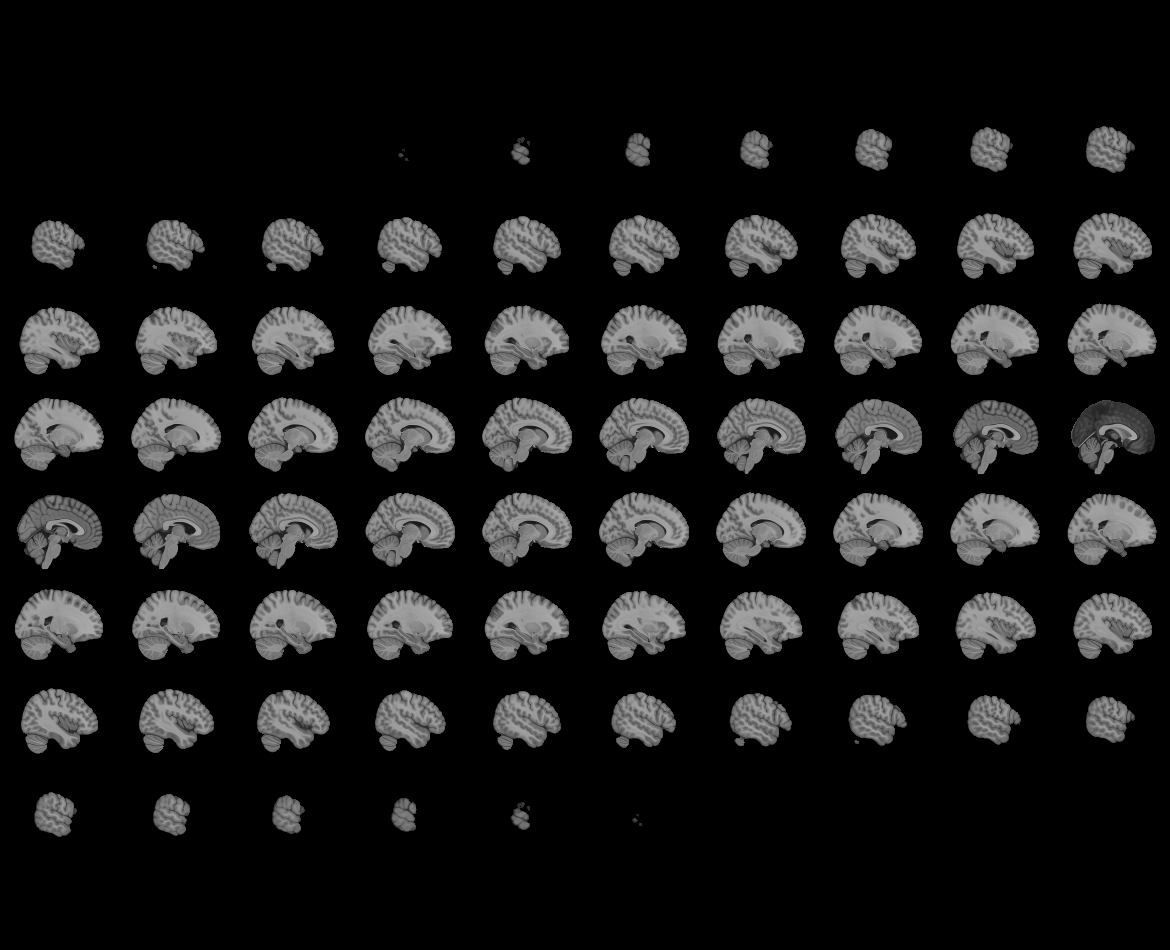
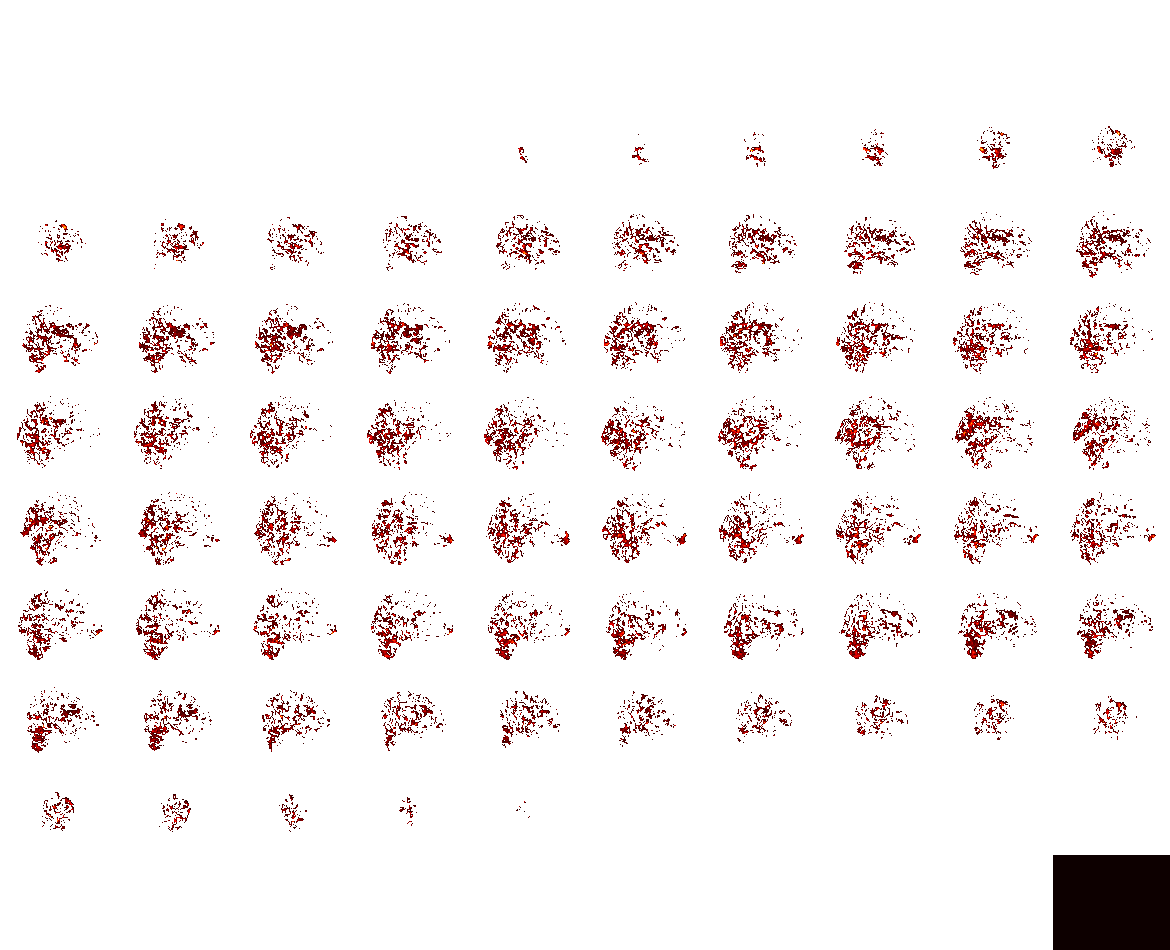

In [27]:
# plot the cv_scores_mean_i
plotting.view_img(
    mean_img_coef,
    title=f'{subfolder_name}',
    threshold="95%",
    cut_coords=(0, 0, 0),
    draw_cross=True,)


# 3. Classification using scikit routines
### Preparing the fmri Data to 2D

In [30]:
masker = NiftiMasker(
    mask_img=mask_img,
    standardize="zscore_sample",
    runs= runs_group,
    smoothing_fwhm = 4,
    memory="nilearn_cache"
    )
X_masked = masker.fit_transform(X)

In [31]:
selector = SelectKBest(f_classif, k=52000)
#using anova as it

In [32]:
svc_ovo = OneVsOneClassifier(
    Pipeline(
        [
            ("anova", selector),
            ("svc", SVC(kernel="linear")),
        ]
    )
)

In [33]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average, multi_class):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average, multi_class = multi_class)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

In [34]:
n_splits = len(np.unique(runs_group))

logo = LeaveOneGroupOut()

### Confusion Matrix

In [35]:
from sklearn.metrics import confusion_matrix

accuracy = {}
lr_roc_auc_multiclass  = {}
roc_vals_mc = {}
cm = {}

f=0
for train_index, test_index in logo.split(X_masked, y, groups=runs_group):
    
    
    X_train, X_test = X_masked[train_index], X_masked[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svc_ovo.fit(X_train, y_train)

    y_pred = svc_ovo.predict(X_test)
    

    # compute the confusion matrix
    cm[f] = confusion_matrix(y_test, y_pred)

    # We will store the results in a dictionary for easy access later
    per_class_accuracies = {}

     # Calculate the accuracy for each one of our classes
    for idx, cls in enumerate(set(y_test)):
        # True negatives are all the samples that are not our current GT class (not the current row) and were not predicted as the current class (not the current column)
        true_negatives = np.sum(np.delete(np.delete(cm[f], idx, axis=0), idx, axis=1))
        
        # True positives are all the samples of our current GT class that were predicted as such
        true_positives = cm[f][idx, idx]
        
        # The accuracy for the current class is the ratio between correct predictions to all predictions
        per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm[f])

    accuracy[f] = per_class_accuracies

    roc_vals = roc_auc_score_multiclass(y_test, y_pred, average = 'micro', multi_class = 'ovo')


    lr_roc_auc_multiclass[f] = list(roc_vals.values())


    # roc_vals_mc[f] = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

    f += 1
    
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {lr_roc_auc_multiclass}')
   



Accuracy: {0: {0: 0.6666666666666666, 1: 0.8333333333333334, 2: 0.7777777777777778, 3: 0.9444444444444444, 4: 0.6111111111111112, 5: 0.8888888888888888, 6: 0.8333333333333334, 7: 0.8888888888888888, 8: 0.6666666666666666}, 1: {0: 0.7777777777777778, 1: 0.8888888888888888, 2: 0.8333333333333334, 3: 0.8333333333333334, 4: 0.7777777777777778, 5: 0.8333333333333334, 6: 0.8888888888888888, 7: 0.7777777777777778, 8: 0.8333333333333334}, 2: {0: 0.8333333333333334, 1: 0.8888888888888888, 2: 0.8333333333333334, 3: 0.8888888888888888, 4: 0.7222222222222222, 5: 0.8888888888888888, 6: 0.8333333333333334, 7: 0.5555555555555556, 8: 0.8888888888888888}, 3: {0: 0.8333333333333334, 1: 0.8888888888888888, 2: 0.8333333333333334, 3: 0.9444444444444444, 4: 1.0, 5: 0.8888888888888888, 6: 0.8888888888888888, 7: 0.5, 8: 0.8888888888888888}}
ROC AUC: {0: [0.375, 0.46875, 0.4375, 0.75, 0.34375, 0.5, 0.46875, 0.5, 0.375], 1: [0.4375, 0.71875, 0.46875, 0.90625, 0.65625, 0.46875, 0.5, 0.4375, 0.46875], 2: [0.46875

In [39]:
cv_accuracy = [list(accuracy[i].values()) for i in range(len(accuracy))]


print(cv_accuracy)

[[0.6666666666666666, 0.8333333333333334, 0.7777777777777778, 0.9444444444444444, 0.6111111111111112, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888, 0.6666666666666666], [0.7777777777777778, 0.8888888888888888, 0.8333333333333334, 0.8333333333333334, 0.7777777777777778, 0.8333333333333334, 0.8888888888888888, 0.7777777777777778, 0.8333333333333334], [0.8333333333333334, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888, 0.7222222222222222, 0.8888888888888888, 0.8333333333333334, 0.5555555555555556, 0.8888888888888888], [0.8333333333333334, 0.8888888888888888, 0.8333333333333334, 0.9444444444444444, 1.0, 0.8888888888888888, 0.8888888888888888, 0.5, 0.8888888888888888]]


In [ ]:
mean_roc_auc = np.mean(list(lr_roc_auc_multiclass.values()), axis=0)

print(f'Mean ROC AUC: {mean_roc_auc}')



# compute mean of the accuracy
mean_accuracy = np.mean(cv_accuracy, axis=0)

print(f'Mean accuracy: {mean_accuracy}')

Mean ROC AUC: [0.4375    0.546875  0.4609375 0.7265625 0.6015625 0.546875  0.5390625
 0.4921875 0.5703125]
Mean accuracy: [0.77777778 0.875      0.81944444 0.90277778 0.77777778 0.875
 0.86111111 0.68055556 0.81944444]


In [47]:
print(cm[0])

[[0 0 2 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0]
 [2 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 2]
 [0 0 0 0 2 0 0 0 0]
 [0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0]
 [0 0 0 0 2 0 0 0 0]]


[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Text(50.72222222222221, 0.5, 'True')

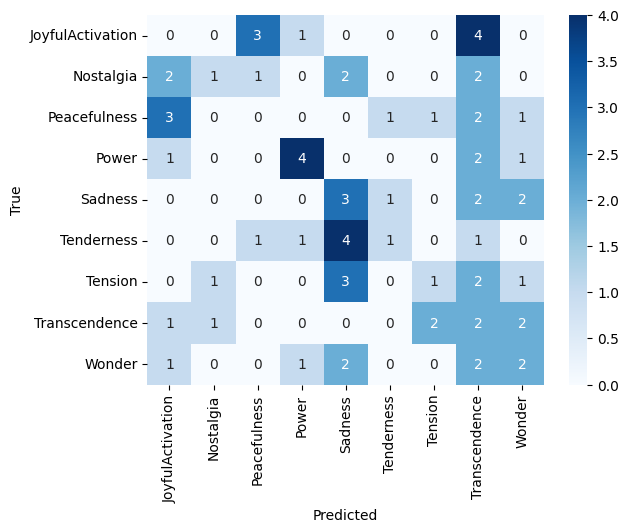

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns

# plot confusion matrix totals
cm_total = np.zeros(cm[0].shape)

for i in range(len(cm)):
    cm_total += cm[i]



sns.heatmap(cm_total, annot= True, fmt='g', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, )

plt.xlabel('Predicted')
plt.ylabel('True')